In [2]:
# Import PyTorch Data Loader Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101
from torchvision import transforms

# Other Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import Dice
import resource
from monai.losses import DiceLoss as MonaiDiceLoss
from monai.networks.nets import DenseNet, UNet, ResNet
from monai.networks.layers import Norm
from sklearn.model_selection import train_test_split
import nibabel as nib
import SimpleITK as sitk

# Custom Imports
from DRAC_Dataloading import DRAC_Loader
from DRAC_Models import ResNetBinary, BinaryDenseNet
from DRAC_Training import train_model
from DRAC_Testing import test_model
#from DRAC_Criterion import DiceLoss
from models_unetpp import UNetPlusPlus
from DRAC_Test_Dataloading import DRAC_Test_Loader

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.0.1'

In [3]:
torchmetrics.__version__

'1.3.2'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [5]:
def current_memory_usage():
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

In [6]:
## Default Variables ##
# Datasets #

# Dataloader #
batch_size = 2 # Batch size of 16

# Model #
model = UNet(
    spatial_dims=2,  # 2D image
    in_channels=1,  # Single-channel input image
    out_channels=1,  # Single-channel output for binary classification
    channels=(4,8,16,8,4),  # Further reduced channels for each layer of the UNet
    strides=(2,2,2,2),  # Reduced number of strides to match the reduced layers
    kernel_size=3,  # Kernel size for the convolutions
    up_kernel_size=3,  # Kernel size for the up-convolutions
    #act='RELU',  # Activation function
    #norm=Norm.INSTANCE,  # Using instance normalization which might be better for small datasets
    #num_res_units=2,  # Reduced number of residual units to simplify the model
).to(device)

model_name = 'UNet-Monai'

criterion = MonaiDiceLoss(
    include_background=True, # Include background as a class for loss calculation
    to_onehot_y=False, # Since your target is already a binary mask, no need for one-hot encoding
    sigmoid=True, # Apply sigmoid activation to ensure the output ranges between 0 and 1
    squared_pred=False # Use squared predictions in the Dice computation
)
criterion_name = 'MonaiDice-Alt'

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 50

print(current_memory_usage())

829.2734375


In [7]:
# Use os to list all items in following directory
directory = "./data/Segmentation/Original/train/"
items = os.listdir(directory)

# Item Locations
item_locations = [directory + item for item in items]

# Split the data into training and validation sets
import random
value = random.randint(0,100)
train_items, val_items = train_test_split(items, test_size=0.2, random_state=value)

In [8]:
# Now make full list with directories
train_items_full = [directory + item for item in train_items]
val_items_full = [directory + item for item in val_items]

In [9]:
# In validation of items, check to see if each item is in various labels in the following locations:
intraretinal_dir = "./data/Segmentation/Groundtruths/intraretinal/"
neovascular_dir = "./data/Segmentation/Groundtruths/neovascular/"
nonperfusion_dir = "./data/Segmentation/Groundtruths/nonperfusion/"

# Cycle through each item in both train_items, find train_items and val_items in the 3 directories for each item, as long as the item is in the train_items or val_items
train_items_intraretinal = [intraretinal_dir + item for item in train_items if item in os.listdir(intraretinal_dir)]
train_items_neovascular = [neovascular_dir + item for item in train_items if item in os.listdir(neovascular_dir)]
train_items_nonperfusion = [nonperfusion_dir + item for item in train_items if item in os.listdir(nonperfusion_dir)]

val_items_intraretinal = [intraretinal_dir + item for item in val_items if item in os.listdir(intraretinal_dir)]
val_items_neovascular = [neovascular_dir + item for item in val_items if item in os.listdir(neovascular_dir)]
val_items_nonperfusion = [nonperfusion_dir + item for item in val_items if item in os.listdir(nonperfusion_dir)]

# Now only give the names of the items, not the full path, for each fo the masks.
train_items_intraretinal_name = [item.split("/")[-1] for item in train_items_intraretinal]
train_items_neovascular_name = [item.split("/")[-1] for item in train_items_neovascular]
train_items_nonperfusion_name = [item.split("/")[-1] for item in train_items_nonperfusion]

val_items_intraretinal_name = [item.split("/")[-1] for item in val_items_intraretinal]
val_items_neovascular_name = [item.split("/")[-1] for item in val_items_neovascular]
val_items_nonperfusion_name = [item.split("/")[-1] for item in val_items_nonperfusion]

In [10]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
# Make a list of datasets
train_datasets = [DRAC_Loader(data = train_items_full, data_names = train_items, labels_loc = train_items_intraretinal, label_names = train_items_intraretinal_name, data_type = 'train', mask = "intraretinal", transform=transforms, rotation = False),
                  DRAC_Loader(data = train_items_full, data_names = train_items, labels_loc = train_items_neovascular, label_names = train_items_neovascular_name, data_type = 'train', mask = "neovascular", transform=transforms, rotation = False),
                  DRAC_Loader(data = train_items_full, data_names = train_items, labels_loc = train_items_nonperfusion, label_names = train_items_nonperfusion_name, data_type = 'train', mask = "nonperfusion", transform=transforms, rotation = False)]

val_datasets = [DRAC_Loader(data = val_items_full, data_names = val_items, labels_loc = val_items_intraretinal, label_names = val_items_intraretinal_name, data_type = 'val', mask = "intraretinal", transform=transforms, rotation = False),
                DRAC_Loader(data = val_items_full, data_names = val_items, labels_loc = val_items_neovascular, label_names = val_items_neovascular_name, data_type = 'val', mask = "neovascular", transform=transforms, rotation = False),
                DRAC_Loader(data = val_items_full, data_names = val_items, labels_loc = val_items_nonperfusion, label_names = val_items_nonperfusion_name, data_type = 'val', mask = "nonperfusion", transform=transforms, rotation = False)]

In [12]:
train_dataloaders = [DataLoader(train_datasets[0], batch_size=batch_size, shuffle=True),
                     DataLoader(train_datasets[1], batch_size=batch_size, shuffle=True),
                     DataLoader(train_datasets[2], batch_size=batch_size, shuffle=True)]

val_dataloaders = [DataLoader(val_datasets[0], batch_size=batch_size, shuffle=True),
                     DataLoader(val_datasets[1], batch_size=batch_size, shuffle=True),
                     DataLoader(val_datasets[2], batch_size=batch_size, shuffle=True)]

In [13]:
# Print the length of all datasets
len(train_datasets[0]), len(val_datasets[0]), len(train_datasets[1]), len(val_datasets[1]), len(train_datasets[2]), len(val_datasets[2])

(87, 22, 87, 22, 87, 22)

In [14]:
loader_names = ['Intraretinal', 'Neovascularization', 'Nonperfusion']

folder = f'models/{model_name}_{batch_size}_{epochs}_{criterion_name}'

def createModelFolder(directory):
    # Check to see if the folder exists, if not, create it. If it does, cycle through number interations until a new folder is created.
    if not os.path.exists(directory):
        os.makedirs(directory)
        return directory
    else:
        i = 1
        while os.path.exists(f'{directory}_{i}'):
            i += 1
        folder = f'{directory}_{i}'
        os.makedirs(directory)
        return folder

# Create the folder
all_losses = []
count = 0
create = True

for i in range(3):
    statistics = train_model(model, train_dataloaders[i], val_dataloaders[i],
                             criterion, optimizer, epochs=epochs, criterion_name=criterion_name,
                             segmentation_name=loader_names[i])

    if create:
        # Check first to see if folder does not exist
        if not os.path.exists(folder):
            folder = createModelFolder(folder)
        
        create = False
    
    # Save in the folder
    torch.save(model.state_dict(), f'{folder}/model_{loader_names[i]}.pt')
    
    # Append the "statistics" item to the all_losses list
    all_losses.append(statistics)

Epoch: 1/50 | Training Loss: 0.9758 | Validation Loss: 0.9675 | Time: 1.12 seconds
Epoch: 2/50 | Training Loss: 0.9538 | Validation Loss: 0.9395 | Time: 0.77 seconds
Epoch: 3/50 | Training Loss: 0.9107 | Validation Loss: 0.8896 | Time: 0.77 seconds
Epoch: 4/50 | Training Loss: 0.8730 | Validation Loss: 0.8609 | Time: 0.75 seconds
Epoch: 5/50 | Training Loss: 0.8407 | Validation Loss: 0.8108 | Time: 0.78 seconds
Epoch: 6/50 | Training Loss: 0.7974 | Validation Loss: 0.7961 | Time: 0.76 seconds
Epoch: 7/50 | Training Loss: 0.7626 | Validation Loss: 0.8065 | Time: 0.76 seconds
Epoch: 8/50 | Training Loss: 0.7508 | Validation Loss: 0.7929 | Time: 0.76 seconds
Epoch: 9/50 | Training Loss: 0.7210 | Validation Loss: 0.8030 | Time: 0.78 seconds
Epoch: 10/50 | Training Loss: 0.7083 | Validation Loss: 0.7934 | Time: 0.76 seconds
Epoch: 11/50 | Training Loss: 0.6933 | Validation Loss: 0.7945 | Time: 0.77 seconds
Epoch: 12/50 | Training Loss: 0.6567 | Validation Loss: 0.8192 | Time: 0.76 seconds
E

In [15]:
stat1 = all_losses[0]

# Load "train_loss" from the statistics.
train_loss1 = stat1['train_loss']

# Load the "valid_loss" from the statistics.
valid_loss1 = stat1['valid_loss']

train_loss1[:4]

[0.9757947284683035,
 0.9538218319683303,
 0.9107431470910363,
 0.8729711520792556]

In [16]:
# Checks to see if graphs folder exists #
if not os.path.exists('graphs'):
    os.makedirs('graphs')

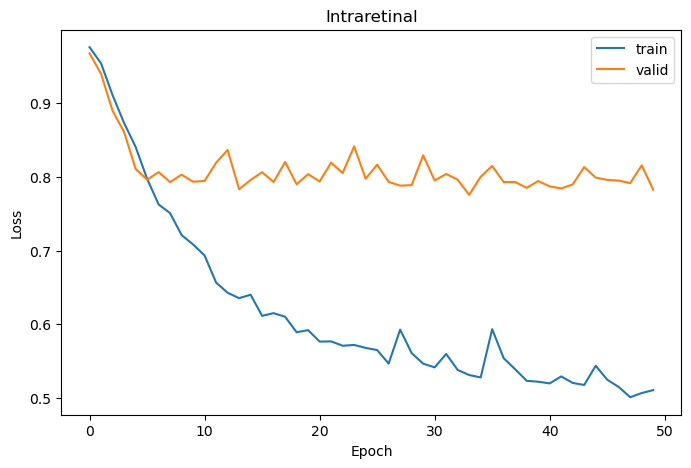

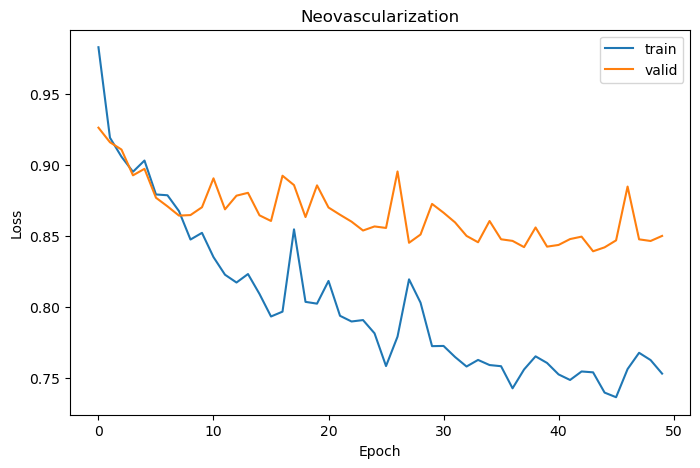

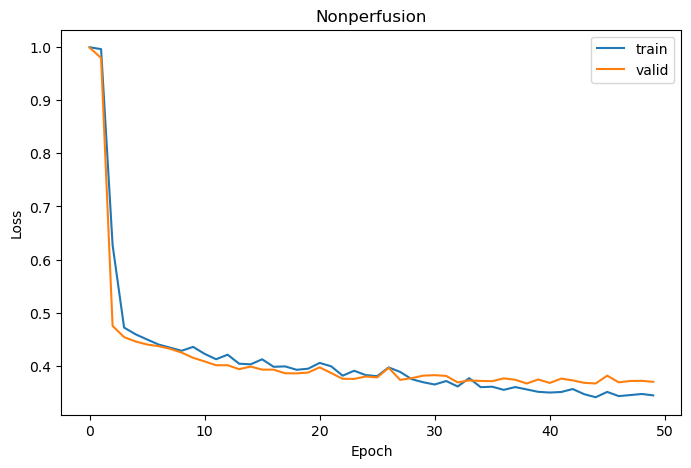

In [17]:
# Plot the loss
plot = True
count = 0
graph_folder = f'graphs/{model_name}_{batch_size}_{epochs}_{criterion_name}'
savegraphs = True

# If graph folder does not exist, create
if not os.path.exists(graph_folder):
    os.makedirs(graph_folder)

for stats in all_losses:
    # Create 3 subplots loading "train_loss" and "valid_loss" on each subplot, with title being loader_names[count]
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(stats['train_loss'], label='train')
    ax.plot(stats['valid_loss'], label='valid')
    ax.set_title(loader_names[count])
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if savegraphs: plt.savefig(f'{graph_folder}/{loader_names[count]}_loss.png')
    plt.show()
    count += 1

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [3]:
# Load in the custom models
name = os.listdir("./models/")

# Print out items with structure "#. model_name"
for i in range(len(name)):
    print(f"{i}. {name[i]}")

0. UNet-Monai-Simplified_6_50_MonaiDice
1. UNet-Monai-SuperSimple_4_50_MonaiDice-Alt
2. UNet-Monai-Simplified_16_50_MonaiDice
3. UNet-Monai_16_35_MonaiDice
4. fcn_resnet50_3_250_DiceLoss
5. fcn_resnet50_2_100_CrossEntropyLoss
6. UNet-Monai_8_5_MonaiDice
7. fcn_resnet50_3_250_DiceLoss_1
8. UNet-Monai_1_50_MonaiDice-Alt
9. UNet-Monai-Simplified_16_350_MonaiDice
10. fcn_resnet50_2_50_CrossEntropyLoss
11. UNet-Monai_2_50_MonaiDice-Alt
12. UNet-Monai_16_200_MonaiDice
13. UNet-Monai-SuperSimple_1_250_MonaiDice-Alt


In [33]:
#file = "./models/" + f'{model_name}_{batch_size}_{epochs}_{criterion_name}' + "/"
file = "./models/" + name[10] + "/"
models = os.listdir(file)
models = [file + model for model in models]

# If any item in the list is a directory, remove it
models = [model for model in models if not os.path.isdir(model)]

# Get the folder name
folder_name = f'{model_name}_{batch_size}_{epochs}_{criterion_name}'

models, folder_name

(['./models/UNet-Monai_2_50_MonaiDice-Alt/model_Intraretinal.pt',
  './models/UNet-Monai_2_50_MonaiDice-Alt/model_Nonperfusion.pt',
  './models/UNet-Monai_2_50_MonaiDice-Alt/model_Neovascularization.pt'],
 'UNet-Monai_2_50_MonaiDice-Alt')

In [34]:
# Within file create folder called "Predictions"
if not os.path.exists(file + "Predictions"):
    os.makedirs(file + "Predictions")

# Set another location
predictions = file + "Predictions/"

In [44]:
# Use os to list all items in following directory
directory = "./data/Segmentation/Original/test/"
items = os.listdir(directory)

# Item Locations
item_locations = [directory + item for item in items]

item_locations[:4], len(item_locations)

(['./data/Segmentation/Original/test/1250.png',
  './data/Segmentation/Original/test/1281.png',
  './data/Segmentation/Original/test/728.png',
  './data/Segmentation/Original/test/1172.png'],
 65)

In [45]:
test_dataset = DRAC_Test_Loader(data = item_locations, data_names = items, transform = transforms)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [57]:
# Print the length of the test dataset
len(test_dataset)

65

In [60]:
count = 0

for model_location in models:    
    # Trained model is located at model_location, load this
    model.load_state_dict(torch.load(model_location))
    
    model.eval()
    
    # Test the model, run if statements...
    if "Intraretinal" in model_location:
        loader = test_dataloader
        loader_name = "Intraretinal"
        nii_file = "1.nii.gz"
    elif "Neovascularization" in model_location:
        loader = test_dataloader
        loader_name = "Neovascularization"
        nii_file = "3.nii.gz"
    elif "Nonperfusion" in model_location:
        loader = test_dataloader
        loader_name = "Nonperfusion"
        nii_file = "2.nii.gz"
    else:
        print("Error")
        break
    
    # Create a pandas dataframe to store the predictions
    df = pd.DataFrame(columns = ["Number", "Name", "Prediction"])
    
    threshold = 0.5
    
    # Get list of names from "loader", removing the .png from the end
    data_names = test_dataset.image_names
    data_numbers = [int(name.split(".")[0]) for name in data_names]
    
    data_count = 0
    print(len(loader[0]))
    for data in loader:        
        inputs = data["image"].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
        
        outputs = ((outputs > threshold).float()).cpu().numpy()  # This will give you a tensor of 0s and 1s
        
        # Add the name and prediction to the dataframe, using pd.concat
        df = pd.concat([df, pd.DataFrame({"Number": [data_numbers[data_count]], "Name": [data_names[data_count]], "Prediction": [outputs]})])
        data_count += 1
    
    #print(df.shape)
    # Reorder the df by the "Name" column, then reset the index
    df = df.sort_values(by = "Number")
    df = df.reset_index(drop = True)
    df = df.drop(columns = ["Number"])
    
    # Now, cycle through the predictions and save them as NIfTI files, using the "Name" as the file name
    final_output = np.zeros((1024, 1024, len(df)))
    
    for i in range(len(df)):
        final_output[:, :, i] = df["Prediction"][i][0, 0, :, :]
    
    # Save the output array to a NIfTI file
    nii_img = nib.Nifti1Image(final_output, np.eye(4))  # Adjust affine as necessary
    
    nib.save(nii_img, f'{predictions}{nii_file}')
    print(f"The model for {loader_name} has been saved as {nii_file} in {predictions}")

The model for Intraretinal has been saved as 1.nii.gz in ./models/UNet-Monai_2_50_MonaiDice-Alt/Predictions/
The model for Nonperfusion has been saved as 2.nii.gz in ./models/UNet-Monai_2_50_MonaiDice-Alt/Predictions/
The model for Neovascularization has been saved as 3.nii.gz in ./models/UNet-Monai_2_50_MonaiDice-Alt/Predictions/


In [61]:
# Load "./models/fcn_resnet50_2_50_CrossEntropyLoss/Predictions/1.nii.gz"
images = [sitk.ReadImage(f"{predictions}1.nii.gz"), sitk.ReadImage(f"{predictions}2.nii.gz"), sitk.ReadImage(f"{predictions}3.nii.gz")]
images

[<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f758974bd80> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f7638143f30> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f758a53a3a0> >]

In [62]:
# Shape of the first image
images[2].GetSize()

(1024, 1024, 33)

(33, 1024, 1024)


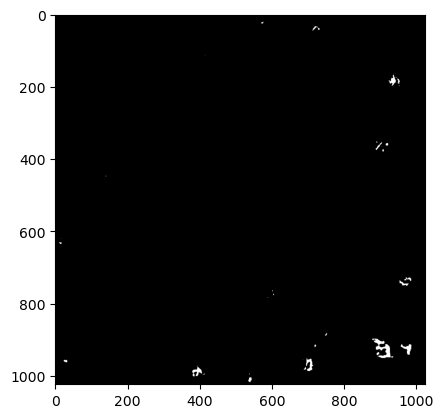

In [63]:
nii1 = sitk.GetArrayFromImage(images[0])
print(nii1.shape)
plt.imshow(nii1[7,:,:], cmap='gray')

IndexError: index 47 is out of bounds for axis 0 with size 33

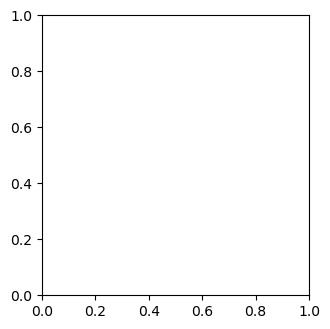

In [64]:
mask_names = ["Intraretinal", "Nonperfusion", "Neovascularization"]
count = 0

# For each item in images:
for image in images:
    # Plot 10 random images in a 2x5 grid
    plt.figure(figsize = (20, 8))
    for i in range(10):
        import random
        j = random.randint(0, 64)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(sitk.GetArrayFromImage(image)[j,:,:], cmap = 'gray')
        plt.axis('off')
        plt.title(f"Slice {j}")
    # Save plot in the same directory, but instead of Predictions do "Plots"
    if not os.path.exists(file + "Plots"):
        os.makedirs(file + "Plots")
    plt.savefig(f"{file}Plots/{mask_names[count]}.png")
    
    plt.show()
    count+=1

In [ ]:
# Get the image dimensions
size = images[0].GetSize()
print("Image size:", size)

# Get the voxel spacing
spacing = images[0].GetSpacing()
print("Voxel spacing:", spacing)

# Get the image origin
origin = images[0].GetOrigin()
print("Image origin:", origin)

# Access the image data as a numpy array
image_array = sitk.GetArrayFromImage(images[0])
print("Image array shape:", image_array.shape)

Image size: (1024, 1024, 33)
Voxel spacing: (1.0, 1.0, 1.0)
Image origin: (0.0, 0.0, 0.0)
Image array shape: (33, 1024, 1024)
